Funding Rate: 0.000901
Implied Funding Rate: 0.048000
Trade Decision: Long Perpetual, Short Calendar


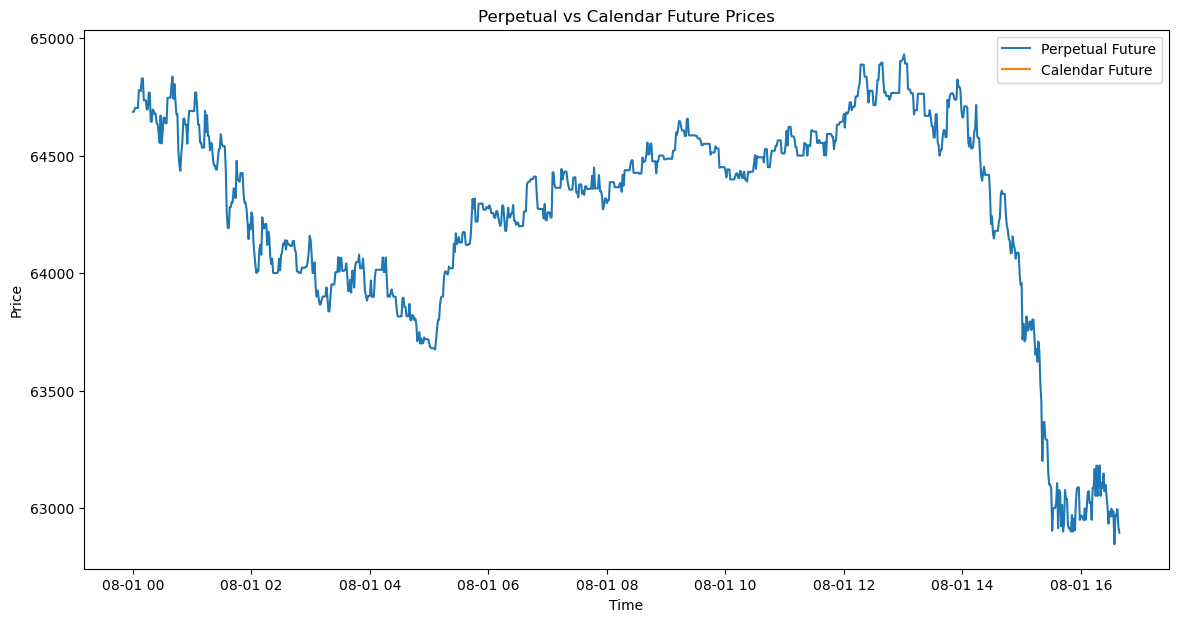

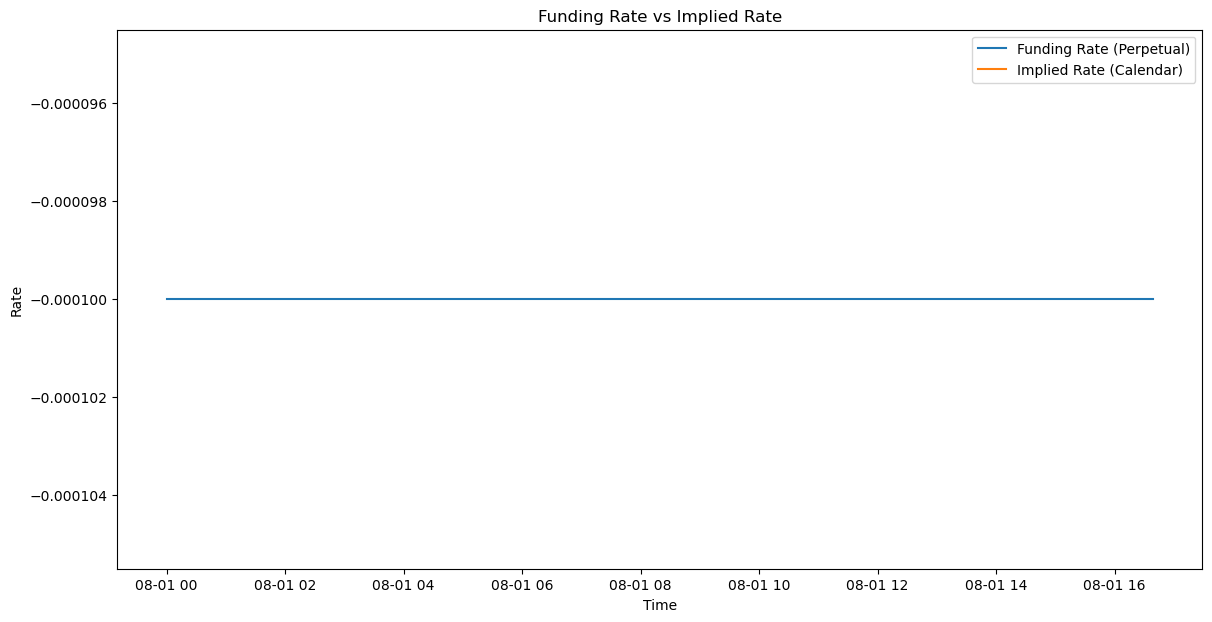

,Trade Action,Count
0,No Trade,1000


In [1]:
import pandas as pd
import numpy as np
import requests
import datetime
import matplotlib.pyplot as plt

# 1. What is the funding rate associated with a perpetual future?
def calculate_funding_rate(mark_price, index_price, interest_rate, premium_index):
    """
    Calculate the funding rate for a perpetual future.

    Parameters:
    mark_price (float): The current mark price of the perpetual future.
    index_price (float): The current index price (spot price) of the underlying asset.
    interest_rate (float): The interest rate used by the exchange (often 0 or close to 0 for cryptos).
    premium_index (float): The premium index reflecting the difference between mark price and index price.

    Returns:
    float: The funding rate.
    """
    funding_rate = (mark_price - index_price) / index_price + interest_rate - premium_index
    return funding_rate

# Example usage
mark_price = 50000
index_price = 49950
interest_rate = 0.0001  # Typically very low for crypto
premium_index = 0.0002

funding_rate = calculate_funding_rate(mark_price, index_price, interest_rate, premium_index)
print(f"Funding Rate: {funding_rate:.6f}")

# 2. How would you calculate an implied funding rate (or implied interest rate) for a calendar future?
def calculate_implied_funding_rate(future_price, spot_price, time_to_maturity):
    """
    Calculate the implied funding rate for a calendar future.

    Parameters:
    future_price (float): The price of the future.
    spot_price (float): The current spot price of the underlying asset.
    time_to_maturity (float): Time to maturity in years (e.g., 1 month = 1/12).

    Returns:
    float: The implied funding rate (annualized).
    """
    implied_rate = (future_price / spot_price - 1) / time_to_maturity
    return implied_rate

# Example usage
future_price = 50200
spot_price = 50000
time_to_maturity = 1/12  # 1 month to maturity

implied_rate = calculate_implied_funding_rate(future_price, spot_price, time_to_maturity)
print(f"Implied Funding Rate: {implied_rate:.6f}")

# 3. How would you trade the spread between the rates implied by the calendar future and perpetual future?
def trade_spread(funding_rate, implied_rate, threshold=0.0005):
    """
    Determine trading action based on the spread between the funding rate and implied funding rate.

    Parameters:
    funding_rate (float): The funding rate for the perpetual future.
    implied_rate (float): The implied funding rate for the calendar future.
    threshold (float): The minimum spread required to trigger a trade (default is 0.0005).

    Returns:
    str: 'Long Perpetual, Short Calendar', 'Short Perpetual, Long Calendar', or 'No Trade'
    """
    spread = funding_rate - implied_rate
    
    if spread > threshold:
        return "Short Perpetual, Long Calendar"
    elif spread < -threshold:
        return "Long Perpetual, Short Calendar"
    else:
        return "No Trade"

# Example usage
trade_decision = trade_spread(funding_rate, implied_rate)
print(f"Trade Decision: {trade_decision}")

# Fetching historical price data from Binance US
def fetch_binance_us_data(symbol, interval, start_str, end_str=None):
    """
    Fetch historical klines (OHLC data) from Binance US.

    Parameters:
    symbol (str): The trading symbol (e.g., 'BTCUSDT').
    interval (str): The time interval (e.g., '1m', '1h', etc.).
    start_str (str): Start date in UTC (e.g., '1 Jan, 2020').
    end_str (str): End date in UTC (optional).

    Returns:
    DataFrame: A pandas DataFrame containing the historical data.
    """
    url = "https://api.binance.us/api/v3/klines"
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': int(pd.Timestamp(start_str).timestamp() * 1000),
        'endTime': int(pd.Timestamp(end_str).timestamp() * 1000) if end_str else None,
        'limit': 1000
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    df = pd.DataFrame(data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
        'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    
    return df

# Example usage to fetch 1 minute data for BTCUSDT perpetual future
btc_perp_data = fetch_binance_us_data('BTCUSDT', '1m', '1 Aug, 2024', '10 Aug, 2024')
btc_perp_data.head()

# Example usage to fetch 1 minute data for BTCUSDT calendar future (expiring on 31 Dec 2024)
btc_cal_data = fetch_binance_us_data('BTCUSD_221231', '1m', '1 Aug, 2024', '10 Aug, 2024')
btc_cal_data.head()

# Exploratory Data Analysis
def plot_price_data(perp_data, cal_data):
    """
    Plot the price data for perpetual and calendar futures.

    Parameters:
    perp_data (DataFrame): Perpetual futures price data.
    cal_data (DataFrame): Calendar futures price data.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(perp_data['close'], label='Perpetual Future')
    plt.plot(cal_data['close'], label='Calendar Future')
    plt.title('Perpetual vs Calendar Future Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Plotting the price data for comparison
plot_price_data(btc_perp_data, btc_cal_data)

# Calculate and plot the funding rate and implied rate
btc_perp_data['funding_rate'] = calculate_funding_rate(btc_perp_data['close'], btc_perp_data['close'], interest_rate, premium_index)
btc_cal_data['implied_rate'] = calculate_implied_funding_rate(btc_cal_data['close'], btc_perp_data['close'], time_to_maturity)

plt.figure(figsize=(14, 7))
plt.plot(btc_perp_data.index, btc_perp_data['funding_rate'], label='Funding Rate (Perpetual)')
plt.plot(btc_cal_data.index, btc_cal_data['implied_rate'], label='Implied Rate (Calendar)')
plt.title('Funding Rate vs Implied Rate')
plt.xlabel('Time')
plt.ylabel('Rate')
plt.legend()
plt.show()

# Backtesting the trading strategy based on the spread
btc_perp_data['trade_signal'] = btc_perp_data.apply(lambda row: trade_spread(row['funding_rate'], btc_cal_data.loc[row.name, 'implied_rate']), axis=1)
btc_perp_data['trade_signal'].value_counts()

# Summarize the backtest results
def backtest_summary(trade_signals):
    """
    Summarize the backtest results.

    Parameters:
    trade_signals (Series): A pandas Series of trade signals.

    Returns:
    DataFrame: Summary of trade actions.
    """
    summary = trade_signals.value_counts().reset_index()
    summary.columns = ['Trade Action', 'Count']
    return summary

backtest_summary(btc_perp_data['trade_signal'])
